In [ ]:
#coding=utf-8

"""
@author: evilXu
@file: testFactor.py
@time: 2017/11/16 17:48
@description: 
"""

from rqalpha.api import *
import traceback
from datetime import *
import pymysql
import pandas as pd
from rqalpha.utils.logger import user_log

# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init():
    user_log.info("test Factor init")


# 你选择的证券的数据更新将会触发此段逻辑，例如日或分钟历史数据切片或者是实时数据切片更新
def compute(startdt,enddt):
    '''
    当日换手率
    :param startdt:
    :param enddt:
    :return:
    '''
    user_log.info("testFactor compute")
    class PlugInBase():
        def __init__(self):
            _jyConnectStr = '{"host":"172.18.44.231","port":3306,"db":"jydb","user":"quant1","passwd":"quant1@591"}'
            _cnnConf = eval(_jyConnectStr)
            self.jyConn = pymysql.connect(host=_cnnConf.get("host"), port=_cnnConf.get("port") \
                                          , db=_cnnConf.get("db"), user=_cnnConf.get("user"),
                                          passwd=_cnnConf.get("passwd"), charset='utf8')

    class secumain(PlugInBase):
        def __init__(self):
            super(secumain, self).__init__()

        def _delistedDate(self):
            _sql = "select InnerCode,ChangeDate,ChangeType from lc_liststatus " \
                   "where ChangeType =4 and SecuMarket in (83,90)"
            _res = {}
            try:
                _cursor = self.jyConn.cursor()
                _cursor.execute(_sql)
                for _row in _cursor:
                    _res[_row[0]] = _row[1]
                return _res
            except Exception as e:
                traceback.print_exc()
                return _res

        def getSecuMain(self, latestUpTs=None, secutype="stock"):
            '''
            便于子类处理innercode,secucode等
            :param latestUpTs:
            :return:
            '''
            _icode2DelistedDate = self._delistedDate()
            _category = [1, ]
            _sectors = [1, 2, 6]
            if secutype == "stock":
                _category = [1, ]
            elif secutype == "index":
                _category = [4, ]
                _sectors = [1, 2, 6, 4]  # 3 3板
            _sql = "select s.innercode, s.ChiName, s.ChiNameAbbr, s.EngName, s.EngNameAbbr" \
                   ", s.SecuAbbr,s.ChiSpelling, s.SecuMarket,s.SecuCategory,s.ListedDate,s.ListedSector" \
                   ",s.ListedState,s.XGRQ,s.SecuCode,s.CompanyCode from secumain s where s.SecuMarket in (83,90) " \
                   "and s.SecuCategory in (%s) and s.ListedSector in (%s) " \
                   "and ListedState!=9" % (",".join([str(i) for i in _category]), ",".join([str(i) for i in _sectors]),)
            if latestUpTs:
                _sql += " and s.XGRQ >= '%s'" % (latestUpTs)
            # print(_sql)
            _res = []
            try:
                _cursor = self.jyConn.cursor()
                _cursor.execute(_sql)
                for _row in _cursor:
                    # print(_row[13])
                    _res.append({
                        "code": self.code(_row[13], _row[7]) if secutype == "stock" else self.indexCode(_row[13],
                                                                                                        _row[7],
                                                                                                        _row[10],
                                                                                                        _row[1]),
                        "chname": _row[1],
                        "chabbr": _row[2],
                        "engname": _row[3],
                        "engabbr": _row[4],
                        "abbr": _row[5],
                        "abbrspelling": _row[6],
                        "market": self.market(_row[7]),
                        "category": self.category(_row[8]),
                        "listeddate": _row[9],
                        "listedsector": self.listSector(_row[10]),
                        "listedtstate": _row[11],  # self.listState(_row[11]),
                        "uptime": _row[12],
                        "InnerCode": _row[0],
                        "CompanyCode": _row[14],
                        "delisteddate": _icode2DelistedDate.get(_row[0])
                    })
                user_log.info("getsecumain,len:{0}", len(_res))
                return _res
            except Exception as e:
                traceback.print_exc()
                return _res

        @classmethod
        def indexCode(cls, rawcode="", market=90, sector=1, name="上证企业债"):
            if sector != 4:
                return rawcode + "." + cls.market(market)
            elif rawcode.find("39") == 0 or rawcode.find("00") == 0:
                return rawcode + "." + cls.market(market)
            elif name.find("上证") == 0 or name.find("深证") == 0:
                return rawcode + "." + cls.market(market)
            else:
                return rawcode + ".SI"

        @classmethod
        def code(cls, rawcode="", market=90):
            return rawcode + "." + cls.market(market)

        @classmethod
        def market(cls, market=90):
            if market == 83:
                return 'XSHG'
            elif market == 90:
                return 'XSHE'
            else:
                return ""

        @classmethod
        def category(cls, categoryType=1):
            if categoryType == 1:
                return "A"
            else:
                return ""

        @classmethod
        def listSector(cls, sector=1):
            if sector == 1:
                return "主板"
            elif sector == 2:
                return "中小板"
            elif sector == 6:
                return "创业板"
            else:
                return "其他"

        @classmethod
        def listState(cls, state=1):
            if state == 1:
                return "上市"
            elif state == 2:
                return "预上市"
            elif state == 3:
                return "暂停"
            elif state == 4:
                return "上市失败"
            elif state == 5:
                return "终止"
            elif state == 9:
                return "其他"
            elif state == 10:
                return "交易"
            elif state == 11:
                return "停牌"
            elif state == 12:
                return "摘牌"
            else:
                return ""

    # 日行情
    class bar(PlugInBase):
        def __init__(self):
            super(bar, self).__init__()

        def _readAYear(self, _innercode2Code={}, stratDt=None, endDt=None):
            _sql = "SELECT p.innerCode,p.TradingDay,p.PrevClosePrice,p.OpenPrice,p.HighPrice,p.LowPrice" \
                   ",p.ClosePrice,p.TurnoverVolume,p.TurnoverValue" \
                   ",p.XGRQ FROM QT_DailyQuote p where p.innerCode in (%s) and p.TradingDay between '%s' and '%s'" % (
                       ",".join(str(i) for i in _innercode2Code.keys()), stratDt.strftime('%Y-%m-%d'),
                       endDt.strftime('%Y-%m-%d'))
            # print(_sql)
            try:
                _now = datetime.now()
                _cursor = self.jyConn.cursor()
                _cursor.execute(_sql)
                for _row in _cursor:
                    if _row[0] not in _innercode2Code:
                        continue
                    yield {
                        "code": _innercode2Code.get(_row[0]),  # secumain.code(_row[0],_row[13]),#
                        "date": _row[1],
                        "preclose": _row[2],
                        "open": _row[3],
                        "high": _row[4],
                        "low": _row[5],
                        "close": _row[6],
                        "volume": _row[7],
                        "amount": _row[8],
                        "amplitude": None,  # _row[9],
                        "turnover": None,  # _row[10],
                        "avg": None,  # _row[11],
                        "uptime": _now
                    }
                return
            except Exception as e:
                traceback.print_exc()
                return

    key = "close"
    _secumainObj = secumain()
    _barObj = bar()
    _innerCode2Code = dict((item['InnerCode'],item['code']) for item in _secumainObj.getSecuMain())
    _bars = [{"code":item['code'],key:item[key],"date":item['date']}for item in _barObj._readAYear(_innerCode2Code,startdt,enddt)]
    _bars = sorted(_bars,key=lambda x:x['date'])
    # print("bars len:", len(_bars),len(_innerCode2Code))
    _res = []
    if len(_bars) >0:
        _lastDt = _bars[0]['date']
        _adt = {"date":_lastDt}
        for item in _bars:
            if item['date'] != _lastDt:
                _res.append(_adt)
                _lastDt = item['date']
                _adt = {"date": _lastDt}
            else:
                _adt.update({item['code']:item[key]})
        if len(_adt) > 1:
            _res.append(_adt)
    # print(len(_res))
    return pd.DataFrame(_res).set_index(['date'])
    # print("testFactor")

if __name__ == "__main__":
    fValue = compute(datetime(2015,6,8),datetime(2015,7,1).date())
    # _fValue_aDay = fValue.iloc[0]
    print(fValue.index.date())

         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!


haha: E:/evilAlpha/rqalpha/rqalpha/config_factor.yml


[2018-01-26 15:19:58.898568] DEBUG: system_log: evaluateRun
2016-06-01 INFO test Factor init
2016-06-01 INFO testFactor compute
2016-06-01 INFO getsecumain,len:
[2018-01-26 15:20:21.194756] INFO: system_log: get factor value success


没有 300738.XSHE 相关数据


D:\Program Files\Anaconda3\envs\rqalpha\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
[2018-01-26 15:21:06.665418] INFO: system_log: 2016-06-01 00:00:00, factorValue len:2869, yieldData len:3546
[2018-01-26 15:21:06.740117] INFO: system_log: 2016-06-08 00:00:00, factorValue len:2869, yieldData len:3546
[2018-01-26 15:21:06.809301] INFO: system_log: 2016-06-17 00:00:00, factorValue len:2869, yieldData len:3546


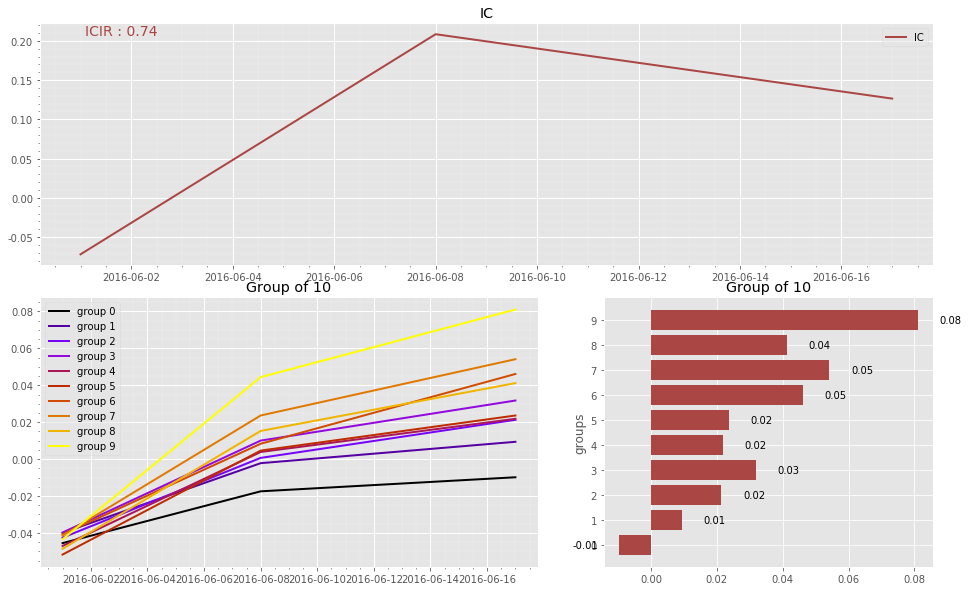

In [1]:
# evaluateFileDemo
from rqalpha.mod.rqalpha_mod_alphaStar_factors import evaluate_file

config = {
  "base": {
    "start_date": "2015-06-01",
    "end_date": "2016-7-01",
  },
}

factor_file_path = "./evaluateFileDemo.ipynb"#"./rqalpha/examples/testFactor.py"

evaluate_file(factor_file_path=factor_file_path,config=config,config_file = "E:/evilAlpha/rqalpha/rqalpha/config_factor.yml")